In [1]:
import pandas as pd
import numpy as np
import verispy, os
from verispy import VERIS

[Source for VERISPY + Useful README](https://github.com/RiskLens/verispy)

In [2]:


DATA_DIR ="./data/validated"
v = VERIS(json_dir=DATA_DIR,schema_url='https://raw.githubusercontent.com/vz-risk/VCDB/master/vcdb-merged.json' ,verbose=True)

vdf = v.json_to_df(keep_raw=True)
# vdf['incident_id']
print(vdf.shape)


Found 8363 json files.
Loading schema
Loading JSON files to DataFrame.


100%|████████████████████████████████████████████████████████████████████████████| 8363/8363 [00:02<00:00, 3905.62it/s]


Finished loading JSON files to dataframe.
Building DataFrame with enumerations.
Building enumeration columns.


100%|████████████████████████████████████████████████████████████████████████████████| 173/173 [00:16<00:00, 10.72it/s]


Done building DataFrame with enumerations.
Post-Processing DataFrame (A4 Names, Victim Industries, Patterns)
Finished building VERIS DataFrame
(8363, 2476)


##### v is a VERIS object. vdf contains the actual data. 

In [3]:
len(set(vdf['incident_id']))
# len(set(vdf['plus.master_id']))

8358

[Good StackOverflow Answer on working with Dataframes vvv](https://stackoverflow.com/questions/17071871/how-to-select-rows-from-a-dataframe-based-on-column-values)

          enum    x     n     freq
0          1.0  882  4711  0.18722
1          2.0   98  4711  0.02080
2       1000.0   57  4711  0.01210
3          3.0   50  4711  0.01061
4       2000.0   41  4711  0.00870
...        ...  ...   ...      ...
1734   26044.0    1  4711  0.00021
1735   67000.0    1  4711  0.00021
1736    1464.0    1  4711  0.00021
1737    1456.0    1  4711  0.00021
1738  385000.0    1  4711  0.00021

[1739 rows x 4 columns]
(4711, 2476)


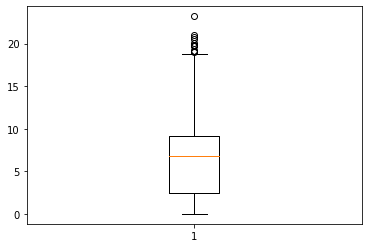

(array([980., 109., 138., 167., 214., 200., 320., 602., 516., 353., 261.,
        173., 129., 104., 102., 105.,  75.,  53.,  48.,  39.,  13.,   6.,
          3.,   0.,   1.]),
 array([ 0.        ,  0.9283269 ,  1.8566538 ,  2.7849807 ,  3.7133076 ,
         4.6416345 ,  5.5699614 ,  6.4982883 ,  7.4266152 ,  8.3549421 ,
         9.28326899, 10.21159589, 11.13992279, 12.06824969, 12.99657659,
        13.92490349, 14.85323039, 15.78155729, 16.70988419, 17.63821109,
        18.56653799, 19.49486489, 20.42319179, 21.35151869, 22.27984559,
        23.20817249]),
 <a list of 25 Patch objects>)

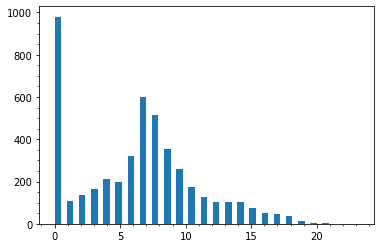

In [4]:
import matplotlib.pyplot as plt
vdf.rename(columns={'attribute.confidentiality.data_total': 'records_lost'}, inplace=True)
vdf
vdf_loss = vdf.dropna(subset=["records_lost"])
vdf_loss['records_lost']
print(v.enum_summary(vdf_loss, 'records_lost'))
# vdf_loss[]
plt.boxplot(np.log(vdf_loss["records_lost"]))
print(vdf_loss.shape)
plt.show()
plt.minorticks_on()
plt.hist(np.log(vdf_loss["records_lost"]), bins = 25, align='mid', width=.5)
    

Total Records Breached, Log Normalized

Employee Counts
               enum     x       n     freq
0       Over 100000   918  3444.0  0.26655
1     1001 to 10000   695  3444.0  0.20180
2       101 to 1000   513  3444.0  0.14895
3         11 to 100   359  3444.0  0.10424
4           1 to 10   267  3444.0  0.07753
5    10001 to 25000   216  3444.0  0.06272
6             Small   185  3444.0  0.05372
7             Large   139  3444.0  0.04036
8    25001 to 50000    99  3444.0  0.02875
9   50001 to 100000    53  3444.0  0.01539
10          Unknown  1267     NaN      NaN


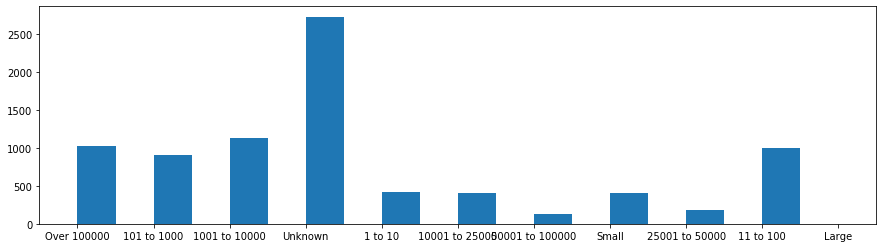

In [5]:

plt.figure(figsize=(15,4))
plt.hist(v.raw_df['victim.employee_count'], align='mid', width = .5) # employee count for the entire distribution

print("Employee Counts")
print(v.enum_summary(vdf_loss, 'victim.employee_count'))
plt.show()
# vdf_loss.assign(employee_count=vdf_loss['victim.employee_count.1 to 10'])

(8363, 173)
(8363, 2476)
(4711, 2476)


C:\Users\jakes\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(array([361., 450., 513.,   0., 732., 245.,   0., 131.,  94., 918.]),
 array([1. , 1.7, 2.4, 3.1, 3.8, 4.5, 5.2, 5.9, 6.6, 7.3, 8. ]),
 <a list of 10 Patch objects>)

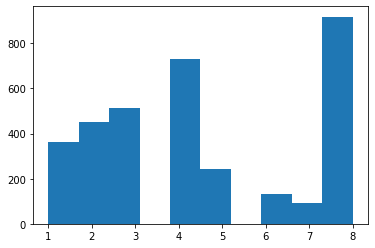

In [6]:
print(v.raw_df.shape)
print(vdf.shape)
print(vdf_loss.shape)
vdf_loss_with_count = vdf_loss.join(v.raw_df['victim.employee_count']) #Takes from original raw dataframe
vdf_loss_wc_known =  vdf_loss_with_count[vdf_loss_with_count['victim.employee_count'] != 'Unknown' ] #Remove unknown 

emp_counts = v.enumerations['victim.employee_count']
emp_counts

emp_count_map = {'1 to 10' : 1, '11 to 100': 2, '101 to 1000': 3, '1001 to 10000': 4, '10001 to 25000': 5, '25001 to 50000': 6, '50001 to 100000': 7, 'Over 100000': 8}

def order_emp_count(row):
    b = row['victim.employee_count']
    if b == 'Small':
        return np.random.randint(1,3)
    if b == 'Large':
        return np.random.randint(4,8)
    return emp_count_map[b]

vdf_loss_wc_known['emp_ord'] = vdf_loss_wc_known.apply(order_emp_count, axis=1)
vdf_loss_wc_known
plt.hist(vdf_loss_wc_known['emp_ord'])

In [7]:
def assign_bugs(row):
    return row['action.Malware'] | row['action.Hacking']
        
vdf_loss_wc_known['action.Bugs'] = vdf_loss_wc_known.apply(assign_bugs, axis=1)



C:\Users\jakes\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [8]:
vdf_loss_wc_known

,action.Environmental,action.Error,action.Hacking,action.Malware,action.Misuse,action.Physical,action.Social,action.Unknown,action.environmental.notes,action.environmental.variety.Deterioration,...,victim.revenue.iso_currency_code.ZMK,victim.revenue.iso_currency_code.ZWD,victim.secondary.amount,victim.secondary.notes,victim.secondary.victim_id,victim.state,victim.victim_id,victim.employee_count,emp_ord,action.Bugs
0,False,False,False,False,True,False,False,False,NaN,False,...,False,False,NaN,NaN,NaN,MO,United States Department of Veterans Affairs,Over 100000,8,False
4,False,True,False,False,False,False,False,False,NaN,False,...,False,False,NaN,NaN,NaN,PA,United States Department of Veterans Affairs,Over 100000,8,False
5,False,True,False,False,False,False,False,False,NaN,False,...,False,False,NaN,NaN,NaN,PA,United States Department of Veterans Affairs,Over 100000,8,False
8,False,False,False,False,False,True,False,False,NaN,False,...,False,False,NaN,NaN,NaN,CA,Sutter Medical Foundation,1 to 10,1,False
11,False,True,False,False,False,False,False,False,NaN,False,...,False,False,NaN,NaN,NaN,NH,United States Department of Veterans Affairs,Over 100000,8,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8349,False,False,False,False,False,True,False,False,NaN,False,...,False,False,NaN,NaN,NaN,TX,Children’s Medical Center of Dallas,1001 to 10000,4,False
8350,False,False,False,False,True,False,False,False,NaN,False,...,False,False,NaN,NaN,NaN,PA,Penn State Hershey Medical Center,1001 to 10000,4,False
8352,False,True,False,False,False,False,False,False,NaN,False,...,False,False,NaN,NaN,NaN,IL,Silver Cross Hospital,1001 to 10000,4,False
8357,False,False,True,False,False,False,False,False,NaN,False,...,False,False,NaN,NaN,NaN,NaN,Al Zahra Private Medical Centre,101 to 1000,3,True


In [9]:
# df_final['action.Bugs'] = bugs
# df_final


In [10]:
#Creates a smaller table for ease of running
# N = 1000
# sample = np.random.choice(8323, N)
# df_short = df_final.iloc[sample,:].reset_index().iloc[:,1:]


# Maybe we should id the column here in the future so we can refer to the original table values

In [11]:
# impactful_df = vdf[vdf['impact.overall_rating.Insignificant'] | vdf['impact.overall_rating.Distracting'] | vdf['impact.overall_rating.Painful'] | vdf['impact.overall_rating.Catastrophic'] | vdf['impact.overall_rating.Damaging']].reindex()
# reset_impactful_df = impactful_df.reset_index(drop=True) #Resets the indicies
# impactful_df_bugs = reset_impactful_df[reset_impactful_df['action.Hacking'] | reset_impactful_df['action.Malware']]
# impactful_df_bugs


In [12]:
# indices = list(impactful_df_bugs.index)
# bugs = [False] * impactful_df.shape[0]
# for i in indices:
#     bugs[i] = True
# overall_rating = reset_impactful_df.loc[:, reset_impactful_df.columns.str.startswith('impact.overall_rating')]
# df_final = reset_impactful_df.iloc[:, :7]
# df_final['action.Bugs'] = bugs
# result = pd.concat([df_final,overall_rating], axis=1, sort=False)
# result = result.iloc[:,:13]
# result 

In [13]:
#result['outcome'] 

#imp_name = "impact.overall_rating"
#result.apply(outcome: lambda outcome + 1, axis = 1)
#idxs = range(len(result))
#for i in idxs:
#    for rank in ranking.keys():
#        if result.[i][rank]:
#            print(rank) = 
#     for 
#             print result[rank]
# ranking

In [14]:
# impact = [0] * result.shape[0]
# for i in range(result.shape[0]):
#     if(result.loc[i, 'impact.overall_rating.Insignificant']):
#         impact[i] = 1
#     elif(result.loc[i, 'impact.overall_rating.Distracting']):
#         impact[i] = 2
#     elif(result.loc[i, 'impact.overall_rating.Painful']):
#         impact[i] = 3
#     elif(result.loc[i, 'impact.overall_rating.Damaging']):
#         impact[i] = 4
#     elif(result.loc[i, 'impact.overall_rating.Catastrophic']):
#         impact[i] = 5
# result['action.Impact'] = impact #Impact rating column is named 'action.Impact'
# result = result.loc[:, result.columns.str.startswith('action')] #CURRENT FINAL DATAFRAME
# result
# import matplotlib.pyplot as plt
# plt.hist(result["action.Impact"])

In [15]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy.do_why import CausalModel
import graphviz
import dowhy.datasets, dowhy.plotter 

In [16]:
import sys
print(sys.version)

3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]


In [17]:
data = dowhy.datasets.linear_dataset(beta=10,
        num_common_causes=5,
        num_instruments = 2,
        num_samples=10000,
        treatment_is_binary=True)
df = data["df"]
df

,Z0,Z1,X0,X1,X2,X3,X4,v,y
0,0.0,0.742650,0.146523,1.439346,1.559191,-1.482484,-1.421735,0.0,-0.136939
1,1.0,0.636159,-0.543185,-0.607693,-1.274166,0.242849,-1.058783,1.0,-3.717449
2,1.0,0.652129,-0.089700,-0.356397,0.889140,0.295827,-1.452092,1.0,7.683239
3,0.0,0.558715,0.562613,1.062901,-0.431749,-1.861730,-0.198629,0.0,-5.351451
4,0.0,0.857788,0.973238,-0.564523,1.057331,0.280319,-2.032337,1.0,9.545255
...,...,...,...,...,...,...,...,...,...
9995,1.0,0.070750,-0.588399,-1.212353,2.434138,-1.110123,-1.995518,0.0,-8.042138
9996,0.0,0.163480,0.817579,-0.262728,1.377430,-1.964894,0.073948,0.0,0.942898
9997,0.0,0.786705,1.068955,-1.521686,-0.507577,0.078940,0.848793,1.0,11.279924
9998,0.0,0.999698,-0.146932,-0.037902,-0.192823,0.130039,-0.959519,0.0,-5.266319


0            1.0
4           87.0
5           87.0
8       943434.0
11           1.0
          ...   
8349      2462.0
8350      1800.0
8352      8862.0
8357      5044.0
8362         1.0
Name: records_lost, Length: 3444, dtype: float64


INFO:dowhy.do_why:Model to find the causal effect of treatment ['action.Bugs'] on outcome ['records_lost']
INFO:dowhy.causal_graph:Using Matplotlib for plotting
C:\Users\jakes\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\jakes\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


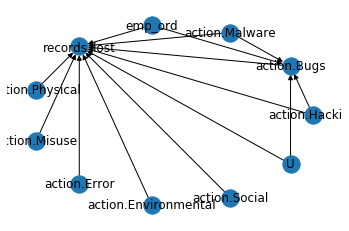

In [41]:
import graphviz
#Create causal model with instrumental
vdf_final = vdf_loss_wc_known # simplicity
# print(vdf)
data
print(vdf_final['records_lost'])

model = CausalModel(
    data = vdf_final,
    treatment = 'action.Bugs',
    outcome = 'records_lost',
    graph = './NetworkXTest/test.gml',
)
vdf_final['action.Bugs']
model.view_model(layout="dot")

INFO:dowhy.causal_graph:Using Matplotlib for plotting


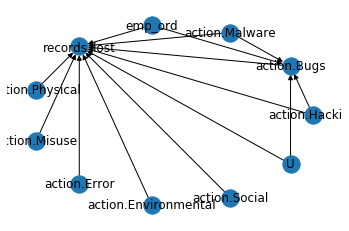

In [42]:
model.view_model()

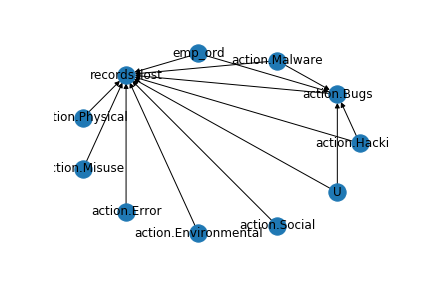

In [43]:
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

We get a causal graph. Now identification and estimation is done. 

In [45]:
identified_estimand = model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['action.Hacking', 'emp_ord', 'action.Malware', 'U']


WARN: Do you want to continue by ignoring these unobserved confounders? [y/n]  y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                       
────────────(Expectation(records_lost|action.Hacking,emp_ord,action.Malware))
daction.Bugs                                                                 
Estimand assumption 1, Unconfoundedness: If U→action.Bugs and U→records_lost then P(records_lost|action.Bugs,action.Hacking,emp_ord,action.Malware,U) = P(records_lost|action.Bugs,action.Hacking,emp_ord,action.Malware)
### Estimand : 2
Estimand name: iv
No such variable found!



INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: records_lost~action.Bugs+action.Hacking+emp_ord+action.Malware


Causal Estimate is 21294214.911130585


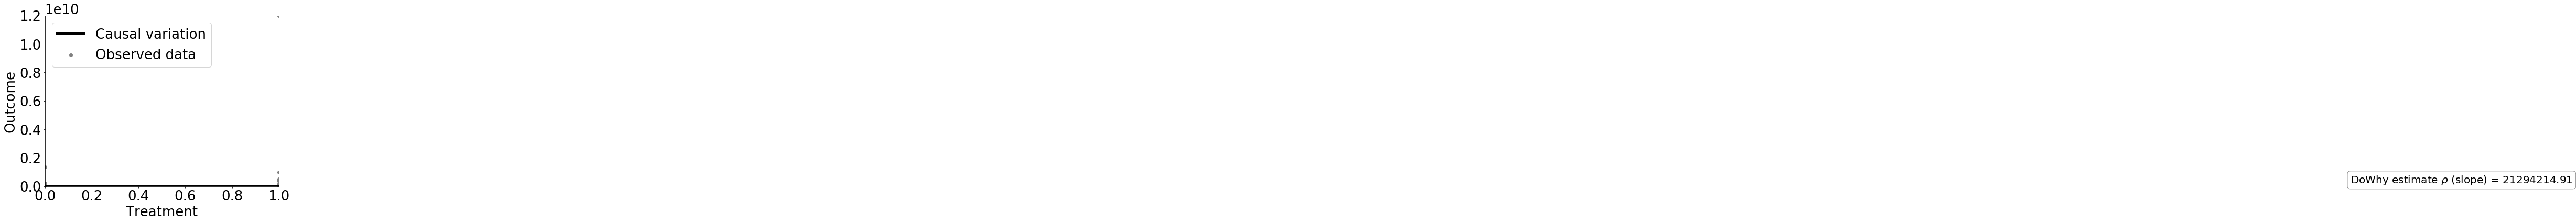

In [50]:
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print("Causal Estimate is " + str(estimate.value))

# Plot Slope of line between treamtent and outcome =causal effect
dowhy.plotter.plot_causal_effect(estimate, vdf_final['action.Bugs'], vdf_final['records_lost'])
# I think the issue is our data isn't giving us a linear plot... this is linear regression after all

In [51]:
print("DoWhy estimate is " + str(estimate.value))
rvar = 1 if np.random.uniform() >0.5 else 0
print ("Actual true causal effect was {0}".format(rvar))

DoWhy estimate is 21294214.911130585
Actual true causal effect was 0


In [52]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['action.Hacking', 'emp_ord', 'action.Malware', 'U']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                       
────────────(Expectation(records_lost|action.Hacking,emp_ord,action.Malware))
daction.Bugs                                                                 
Estimand assumption 1, Unconfoundedness: If U→action.Bugs and U→records_lost then P(records_lost|action.Bugs,action.Hacking,emp_ord,action.Malware,U) = P(records_lost|action.Bugs,action.Hacking,emp_ord,action.Malware)
### Estimand : 2
Estimand name: iv
No such variable found!



## Method 1: Stratification

In [53]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: records_lost~action.Bugs+action.Hacking+emp_ord+action.Malware
C:\Users\jakes\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jakes\Anaconda3\lib\site-packages\dowhy\causal_estimators\propensity_score_stratification_estimator.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._data['propensity_score'] = propensity_score_model.predict_proba(self._observed_common_causes)[:,1]
C:\Users\jakes\Anaconda3\lib\site-packages\dowhy\causal_estimators\propensity_score_stratification_estimator

*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                       
────────────(Expectation(records_lost|action.Hacking,emp_ord,action.Malware))
daction.Bugs                                                                 
Estimand assumption 1, Unconfoundedness: If U→action.Bugs and U→records_lost then P(records_lost|action.Bugs,action.Hacking,emp_ord,action.Malware,U) = P(records_lost|action.Bugs,action.Hacking,emp_ord,action.Malware)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: records_lost~action.Bugs+action.Hacking+emp_ord+action.Malware
## Estimate
Value: nan

Causal Estimate is nan


## Method 2: Matching

In [54]:
causal_estimate_match = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_matching")
print(causal_estimate_match)
print("Causal Estimate is " + str(causal_estimate_match.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: records_lost~action.Bugs+action.Hacking+emp_ord+action.Malware
C:\Users\jakes\Anaconda3\lib\site-packages\dowhy\causal_estimators\propensity_score_matching_estimator.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._data['propensity_score'] = propensity_score_model.predict_proba(self._observed_common_causes)[:,1]
C:\Users\jakes\Anaconda3\lib\site-packages\dowhy\causal_estimators\propensity_score_matching_estimator.py:51: FutureWarning: `item` has been deprecated and will be removed in a future version
  control_outcome = control.iloc[indices[i]][self._outcome_name].item()


*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                       
────────────(Expectation(records_lost|action.Hacking,emp_ord,action.Malware))
daction.Bugs                                                                 
Estimand assumption 1, Unconfoundedness: If U→action.Bugs and U→records_lost then P(records_lost|action.Bugs,action.Hacking,emp_ord,action.Malware,U) = P(records_lost|action.Bugs,action.Hacking,emp_ord,action.Malware)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: records_lost~action.Bugs+action.Hacking+emp_ord+action.Malware
## Estimate
Value: 26470039.98527246

Causal Estimate is 26470039.98527246
